# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.330599,False,0.672998
1,1.789237,True,4.940364
2,1.218110,True,6.731556
3,0.680724,False,0.309219
4,-0.176406,True,2.774351
...,...,...,...
995,-0.461752,False,-0.704051
996,-0.916287,False,-1.607504
997,2.252837,True,7.021005
998,0.955688,True,6.498294


<AxesSubplot: xlabel='v0'>

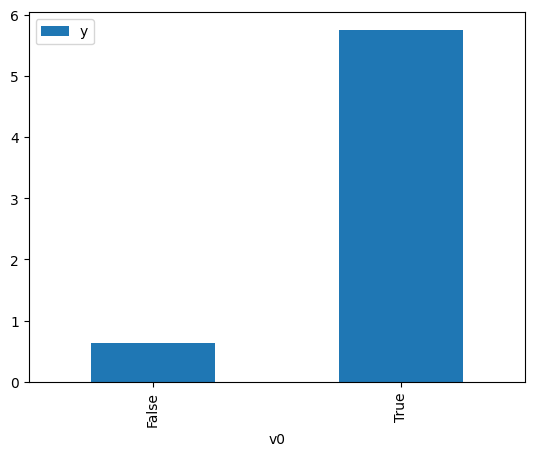

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

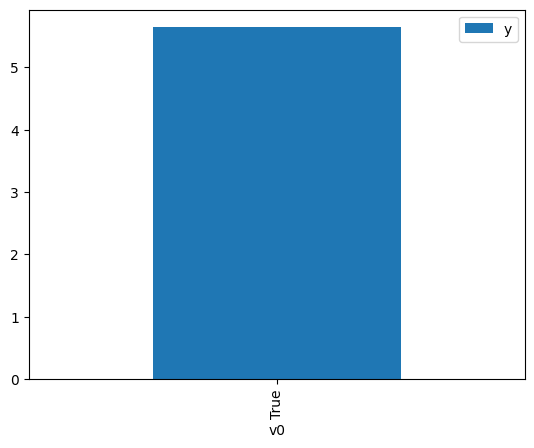

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.034454,False,-0.550549,0.556332,1.797489
1,-0.967286,False,-1.816394,0.880959,1.135127
2,1.326094,False,1.571069,0.086042,11.622193
3,0.063416,False,0.919483,0.510007,1.960757
4,0.662117,False,0.313648,0.249863,4.002195
...,...,...,...,...,...
995,0.569640,False,1.110416,0.284275,3.517717
996,0.437994,False,2.423052,0.337866,2.959752
997,0.209768,False,0.783032,0.440659,2.269326
998,-0.427384,False,-0.055657,0.725929,1.377545


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.396440,True,2.950645,0.285942,3.497216
1,1.509010,True,5.548437,0.937675,1.066467
2,0.760363,True,5.768622,0.783523,1.276288
3,2.019548,True,6.297034,0.975461,1.025156
4,1.340489,True,7.295292,0.916088,1.091599
...,...,...,...,...,...
995,0.915166,True,6.216560,0.829334,1.205786
996,1.666341,True,7.883486,0.953045,1.049269
997,0.020107,True,4.150595,0.469425,2.130268
998,0.741277,True,5.248017,0.777298,1.286507


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.297e+04
Date:                Wed, 23 Nov 2022   Prob (F-statistic):                        0.00
Time:                        09:30:03   Log-Likelihood:                         -1409.0
No. Observations:                1000   AIC:                                      2822.
Df Residuals:                     998   BIC:                                      2832.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1927      0.039     30.749      0.000       1.117       1.269
x2             4.9319      0.056     88.752      0.000       4.823       5.041
==============================================================================
Omnibus:                        4.302   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.116   Jarque-Bera (JB):                4.339
Skew:                          -0.143   Prob(JB):                        0.114
Kurtosis:                       2.852   Cond. No.                         2.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""